# Implementación 
### Equipo: 

In [1]:
# Parámetros generales del notebook
ruta_bases = 'bases/'
sample_size =  2000
cv = 3

In [2]:
# Preparación ambiente AWS SageMaker
#!pip install --upgrade pip
#!pip install xgboost
#!pip install lightgbm
#!pip install -U scikit_learn
#!pip install -U pandas
#!pip install -U matplotlib
#!pip install -U seaborn

In [3]:
# Importación de librerías
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import funciones as fn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from ml_classes import PrepML, MLModel
from matplotlib.pyplot import rcParams
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge,SGDRegressor
from lib.get_nhtsa_json import get_nhtsa_json

In [4]:
# Parámetros generales para plots
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 8
plt.style.use('ggplot')
# Semilla pseudo-aleatoria
rd_seed = 1234

# 0. Obtener la información

Esta es una demostración del proceso realizado por `get_features.py` para poder obtener información relacionada con el `Vin` de los vehículos a través de una API. El proceso consite en los siguientes pasos:
* 1.- Extraer todos los `Vin` de la base completa `true_car_listings.csv`.
* 2.- Requerir a través de la Api 'chunks' de 50 registros por cada petición.
* 3.- Guardar en la memoria el json en formato texto, agregando 50 registros por cada iteración.
* 4.- Una vez completada las iteraciones guardar en formato json todos los registros requeridos.

In [5]:
# Requerimos todos los 'Vin'    
all_vins = pd.read_csv(f'{ruta_bases}true_car_listings.csv')['Vin'].to_list()
# Parámetros de muestra
start = 8
end = 8

json_text = '['
for i in range(start, end+1):
    # Generar requerimiento con 50 registros Vin
    vin_list = all_vins[50 * (i - 1):50 * i]
    json_text += get_nhtsa_json(vin_list, i)

# Cerrar lista de Json
json_text = json_text[:-2] + ']'
# Exportar resultados a archivo json
with open(f'api_test/data_{start}_{end}.json', 'w') as json_file:
    json_file.write(json_text)

8: 9.2s


Paralelamente, en base a una muestra de la base total, se definió el primer filtro de variables requeridas a través la API: que tengan menos del 10% de datos perdidos, las cuales se presentan a continaución:

In [6]:
cols = ['AirBagLocFront', 'BodyClass', 'BusFloorConfigType', 'BusType',
       'CustomMotorcycleType', 'DisplacementCC', 'DisplacementCI',
       'DisplacementL', 'Doors', 'EngineCylinders', 'EngineHP', 'EngineKW',
       'ErrorCode', 'ErrorText', 'FuelTypePrimary', 'Make', 'Manufacturer',
       'ManufacturerId', 'Model', 'ModelYear', 'MotorcycleChassisType',
       'MotorcycleSuspensionType', 'PlantCity', 'PlantCountry', 'TPMS',
       'TrailerBodyType', 'TrailerType', 'VIN', 'VehicleType']

Con estas columnas seleccionadas, se procede a importar los archivos json (varios en el proceso original) para luego mapearlos para retraer solo aquellas columnas, creando un DataFrame con ellas y luego exportarlas en un csv.

In [7]:
# Importación de archivo json
filenames = glob.glob('api_test/*.json')
json_list = []

for filename in filenames:
    print(filename)
    with open(filename, 'r') as file:
        # Mapeamos considerando solo las columnas seleccionadas
        data = list(map(fn.get_info, 
                        json.loads(file.read())
                       )
                   )
    json_list += data

# Creación y exortación de DataFrame con features extraídos
data_json = pd.DataFrame(data=json_list,
                         columns=cols)
data_json.to_csv('api_test/data_api.csv')

api_test/data_8_8.json
api_test/data_4_4.json


# 1. Creación del Dataset 

## 1.1 Bases Originales

In [8]:
# Importación de las bases para muestras de entrenamiento y prueba
df_train = pd.read_csv(f'{ruta_bases}true_cars_train.csv',
                       delimiter=";")
df_test = pd.read_csv(f'{ruta_bases}true_cars_test.csv',
                      delimiter=";")
# Dimensiones de las bases
print(f'Base Train: {df_train.shape}\nBase Test: {df_test.shape}')

Base Train: (639145, 8)
Base Test: (212977, 8)


In [9]:
# Información general de muestra de entrenamiento
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639145 entries, 0 to 639144
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    639145 non-null  int64 
 1   Year     639145 non-null  int64 
 2   Mileage  639145 non-null  int64 
 3   City     639145 non-null  object
 4   State    639145 non-null  object
 5   Vin      639145 non-null  object
 6   Make     639145 non-null  object
 7   Model    639145 non-null  object
dtypes: int64(3), object(5)
memory usage: 39.0+ MB


In [10]:
# Creación de atributo 'sample'
df_train['sample'] = 'train'
df_test['sample'] = 'test'

In [11]:
# Unión de ambas bases
df_data = pd.concat([df_train, df_test])
print(f'Base Data: {df_data.shape}')

Base Data: (852122, 9)


## 1.2 Base API

In [12]:
# Importación de la base extraída por el requerimiento a la api
df_api = pd.read_csv(f'{ruta_bases}api_features.csv').drop(columns='Unnamed: 0')
print(f'Base API: {df_api.shape}')

Base API: (846562, 29)


In [13]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846562 entries, 0 to 846561
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AirBagLocFront            797265 non-null  object 
 1   BodyClass                 845535 non-null  object 
 2   BusFloorConfigType        843524 non-null  object 
 3   BusType                   843524 non-null  object 
 4   CustomMotorcycleType      846525 non-null  object 
 5   DisplacementCC            839096 non-null  float64
 6   DisplacementCI            839096 non-null  float64
 7   DisplacementL             839096 non-null  float64
 8   Doors                     739918 non-null  float64
 9   EngineCylinders           735744 non-null  object 
 10  EngineHP                  380764 non-null  object 
 11  EngineKW                  380764 non-null  object 
 12  ErrorCode                 846550 non-null  object 
 13  ErrorText                 846550 non-null  o

In [14]:
# Identificar columnas con solo valores "Not Applicable" 
notapp_series = df_api\
                    .isin(['Not Applicable'])\
                    .sum()
cols2drop = list(notapp_series[notapp_series > 1].index)

In [15]:
# Borrar aquellas columnas 
df_api = df_api.drop(columns=cols2drop)
print(f'Base API: {df_api.shape}')

Base API: (846562, 22)


In [16]:
df_api=df_api.rename(columns={"AirBagLocFront":"d_AirBagLocFront",
                        "BodyClass":"d_BodyClass",
                        "DisplacementCC":"d_DisplacementCC",
                        "DisplacementCI":"d_DisplacementCI",
                        "DisplacementL":"d_DisplacementL",
                        "Doors":"d_Doors",
                        "EngineCylinders":"d_EngineCylinders",
                        "EngineHP":"d_EngineHP",
                        "EngineKW":"d_EngineKW",
                        "ErrorCode":"d_ErrorCode",
                        "ErrorText":"d_ErrorText",
                        "FuelTypePrimary":"d_FuelTypePrimary",
                        "Make":"d_Make",
                        "Manufacturer":"d_Manufacturer",
                        "ManufacturerId":"d_ManufacturerId",
                        "Model":"d_Model",
                        "ModelYear":"d_ModelYear",
                        "PlantCity":"d_PlantCity",
                        "PlantCountry":"d_PlantCountry",
                        "TPMS":"d_TPMS",
                        "VIN":"Vin",
                        "VehicleType":"d_VehicleType"})

## 1.3 Unión de Bases

In [17]:
# Unión de bases
df = pd.merge(left=df_data, 
              right=df_api, 
              how='inner',
              on='Vin')
# Dimensiones de la base
print(f'Dataset: {df.shape}')

Dataset: (846644, 30)


In [18]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846644 entries, 0 to 846643
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              846644 non-null  int64  
 1   Year               846644 non-null  int64  
 2   Mileage            846644 non-null  int64  
 3   City               846644 non-null  object 
 4   State              846644 non-null  object 
 5   Vin                846644 non-null  object 
 6   Make               846644 non-null  object 
 7   Model              846644 non-null  object 
 8   sample             846644 non-null  object 
 9   d_AirBagLocFront   797359 non-null  object 
 10  d_BodyClass        845629 non-null  object 
 11  d_DisplacementCC   839190 non-null  float64
 12  d_DisplacementCI   839190 non-null  float64
 13  d_DisplacementL    839190 non-null  float64
 14  d_Doors            740010 non-null  float64
 15  d_EngineCylinders  735838 non-null  object 
 16  d_

## 1.4 Limpieza del Dataset

### 1.4.1 ErrorText

La columna ErrorText, nos entrega información relevante respecto a los datos obtenidos desde la API y su relación con el número único VIN. A partir de ella, se decide mantener solo aquellos datos que se obtuvieron de manera correcta (845778 de 846644). 

In [19]:
# revisamos la columna ErrorText, que entrega información respecto errores en la extracción de los datos
df['d_ErrorText'].value_counts().sort_values()

1 - Check Digit (9th position) does not calculate properly; 4 - VIN corrected, error in one position only (indicated by ! in Suggested VIN), multiple matches found                                                                                            1
6 - Incomplete VIN; 7 - Manufacturer is not registered with NHTSA for sale or importation in the U.S. for use on U.S roads; Please contact the manufacturer directly for more information; 11 - Incorrect Model Year, decoded data may not be accurate         1
1 - Check Digit (9th position) does not calculate properly; 11 - Incorrect Model Year, decoded data may not be accurate                                                                                                                                        1
1 - Check Digit (9th position) does not calculate properly; 2 - VIN corrected, error in one position; 14 - Unable to provide information for all the characters in the VIN.                                                          

In [20]:
# Se mantienen solo los datos extraídos correctamente
df = df[(df['d_ErrorText'] == '0 - VIN decoded clean. Check Digit (9th position) is correct') |
       (df['d_ErrorText'] == '0 - VIN decoded clean. Check Digit (9th position) is correct; 14 - Unable to provide information for all the characters in the VIN.')]

In [21]:
#se eliminan las columnas de error que ya utilizamos
df = df.drop(columns=["d_ErrorCode","d_ErrorText"])

In [22]:
# Limpieza de atributo
df["d_EngineCylinders"] = df["d_EngineCylinders"].map(lambda x: float(str(x)\
                                                                   .replace('12, 8', '12')\
                                                                   .replace('8, 12', '8'))
                                                                   )

### 1.4.2 Nulos, datos duplicados y columnas duplicadas

In [23]:
#Datos nulos
#Mediante "isnull()", sum() y shape() identificamos los atributos con datos nulos y su procentaje relativo.
null = round(df.isnull().sum()/df.shape[0],2) 
null[null>0]

d_AirBagLocFront     0.06
d_DisplacementCC     0.01
d_DisplacementCI     0.01
d_DisplacementL      0.01
d_Doors              0.13
d_EngineCylinders    0.13
d_EngineHP           0.55
d_EngineKW           0.55
d_FuelTypePrimary    0.07
d_PlantCity          0.18
d_PlantCountry       0.06
d_TPMS               0.20
dtype: float64

In [24]:
# Identificar columnas con más de un 15% de datos perdidos
null_series = df_api\
                .isnull()\
                .sum()\
                /df_api.shape[0] 
df = df.drop(columns=list(null_series[null_series > .15].index))

In [25]:
#Datos duplicados
#Observamos la cantidad de registros duplicados en el df.
duplicate_rows_df = df[df.duplicated()]
duplicate_rows_df.shape

(161, 24)

In [26]:
# Eliminamos los registros duplicados
df=df.drop_duplicates()

In [27]:
# Columnas duplicadas
# Chequemos si la columna Model, (data set de la academia) y la columna d_Model (data de la API) son iguales.
(df.Model==df.d_Model).value_counts("%")

False    0.839245
True     0.160755
dtype: float64

In [28]:
# vemos los primeros 5 registros de model y d_model.
df[['Model', 'd_Model']] .head(5)

,Model,d_Model
0,ILX5-Speed,ILX
1,ILX5-Speed,ILX
2,ILXAutomatic,ILX
3,TSXAutomatic,TSX
4,TSX5-Speed,TSX


In [29]:
# chequemos si la columna Make, (data set de la academia) y la columna d_Make (data de la API) son iguales.
(df.Make==df.d_Make).value_counts("%")

False    0.905707
True     0.094293
dtype: float64

In [30]:
# Valores unicos columna make.
np.unique(df.Make)

array(['AM', 'Acura', 'Alfa', 'Aston', 'Audi', 'BMW', 'Bentley', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ferrari',
       'Fisker', 'Ford', 'Freightliner', 'GMC', 'Genesis', 'Geo', 'Honda',
       'Hyundai', 'INFINITI', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Lamborghini', 'Land', 'Lexus', 'Lincoln', 'Lotus', 'MINI',
       'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz',
       'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth',
       'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn',
       'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen',
       'Volvo', 'smart'], dtype=object)

In [31]:
# Valores unicos columna d_make.
np.unique(df.d_Make)

array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE',
       'DODGE, CHRYSLER, VOLKSWAGEN, JEEP, FIAT, RAM, LANCIA', 'FERRARI',
       'FIAT', 'FISKER AUTOMOTIVE', 'FORD', 'FREIGHTLINER', 'GENESIS',
       'GMC', 'GMC, PONTIAC, GEO', 'HONDA', 'HUMMER ', 'HYUNDAI',
       'HYUNDAI, KIA', 'INFINITI', 'ISUZU', 'JAGUAR', 'JEEP', 'KIA',
       'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'LINCOLN', 'LOTUS',
       'MASERATI', 'MAYBACH', 'MAZDA', 'MCLAREN', 'MERCEDES-BENZ',
       'MERCEDES-BENZ, MAYBACH', 'MERCURY', 'MINI', 'MITSUBISHI',
       'NISSAN', 'NISSAN, INFINITI', 'OLDSMOBILE', 'PLYMOUTH', 'PONTIAC',
       'PORSCHE', 'RAM', 'ROLLS ROYCE', 'SAAB', 'SATURN', 'SMART',
       'SPRINTER (DODGE OR FREIGHTLINER)', 'SUBARU', 'SUZUKI', 'TESLA',
       'TOYOTA', 'VOLKSWAGEN', 'VOLVO'], dtype=object)

In [32]:
(df.Year == df.d_ModelYear).value_counts("%")

True     0.999987
False    0.000013
dtype: float64

In [33]:
#eliminación columnas duplicadas provenientes de las API,
df = df.drop(columns=['d_Make',"d_Model","d_ModelYear", 'd_ManufacturerId',
                      'd_DisplacementCI', 'd_DisplacementL'])

In [34]:
# Eliminación de variables no informativas
df = df.drop(columns=['Vin'])

### Comentarios:

Para asegurar la calidad de los registros se revisan los valores nulos y duplicados, en donde podemos observar que los porcentajes de valores nulos por atributo son bastante bajos en general, con excepción de d_engineHP, d_EngineKW y d_TPMS, con valores de 0.55, 0.55 y 0.2 respectivamente. Estas tres variables son candidatas a no ser consideradas en el modelamiento de datos. 

Respecto a los registros duplicados, se detectan 161 registros bajo esta condición, por lo que se procede a su eliminacion.

Se decide eliminar las columnas duplicadas, d_Make y d_Model provenientes de la API. En el caso de d_Make, los nombres de las marcas no vienen normalizados, en cambio en Make si. Finalmente, la columna d_Model viene con menos información asociada al modelo respecto a la columna Model.

In [35]:
# Inspección general después de limpieza
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845617 entries, 0 to 846643
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              845617 non-null  int64  
 1   Year               845617 non-null  int64  
 2   Mileage            845617 non-null  int64  
 3   City               845617 non-null  object 
 4   State              845617 non-null  object 
 5   Make               845617 non-null  object 
 6   Model              845617 non-null  object 
 7   sample             845617 non-null  object 
 8   d_AirBagLocFront   796625 non-null  object 
 9   d_BodyClass        844836 non-null  object 
 10  d_DisplacementCC   838484 non-null  float64
 11  d_Doors            739282 non-null  float64
 12  d_EngineCylinders  735176 non-null  float64
 13  d_FuelTypePrimary  789327 non-null  object 
 14  d_Manufacturer     845617 non-null  object 
 15  d_PlantCountry     797389 non-null  object 
 16  d_

# 2. Análisis exploratorio de datos

## 2.1 Distribución vector objetivo

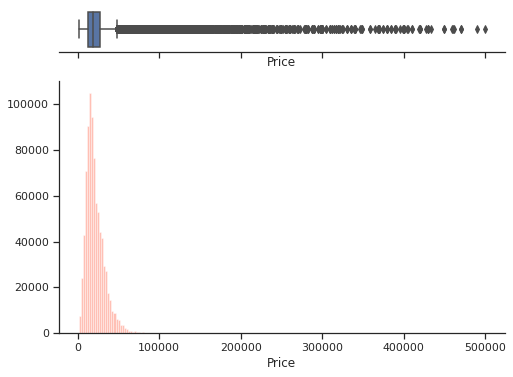

In [36]:
## observamos la distribución del precio mediante un histograma y un gráfico de cajas y bigotes.
fn.distrbution_graph(df.Price)

### Comentarios:

Al observar la distribución del atributo precio (vector objetivo), podemos ver que este es muy variable, teniendo registros con valores muy bajos que parten en los  USD 1.500  como también otros que se disparan del promedio de manera muy marcada alcanzando hasta los USD 499.500. También observamos que la mayoría de los datos se encuetran entre los rangos 0 y 100.000 USD. 

Lo anterior se puede deber a que dentro de la BDD tenemos diferentes tipos de vehiculos cada uno de estos con sus características propias, es por ello que para las demas variables se decide renombrarlas según dichas caracteristicas.

- USE (USE):Atributos relacioados al uso del auto:
Year
Mileage

- SEGMENT (SGT):Atributos asociados al tipo de vehículo:
Vehiculetype
Bodyclass
Make
Model
Manufacture

- FEATURES (FEAT):Atributos asociados las características técnicas del vehículo:
Fuel type
TPMS
Airbag
Displacement
Doors
Engine cilindren

- LOCALIZATION (LOC):Atributos asociados a la ubicación del vehículo:
state
city

- FABRICATION(FAB):Atributo de ubicación de la fabricación:
Plant city
Plant country

In [37]:
#Se renombran los atributos, según lo indicado anteriormente
df=df.rename(columns={"d_AirBagLocFront":"feat_AirBagLocFront",
                        "d_DisplacementCC":"feat_DisplacementCC",
                        "d_Doors":"feat_Doors",
                        "d_EngineCylinders":"feat_EngineCylinders",
                        "d_EngineHP":"feat_EngineHP",
                        "d_EngineKW":"feat_EngineKW",
                        "d_TPMS":"feat_TPMS",
                        "EngineCylinders":"feat_EngineCylinders",  
                        "d_FuelTypePrimary":"feat_FuelTypePrimary",
                        "d_BodyClass":"sgt_BodyClass",  
                        "d_Manufacturer":"sgt_Manufacturer",
                        "d_VehicleType":"sgt_VehicleType",  
                        "Model":"sgt_Model",
                        "Make":"sgt_Make",
                        "d_PlantCity":"fab_PlantCity",
                        "d_PlantCountry":"fab_PlantCountry",
                        "Year":"use_Year",
                        "Mileage":"use_Mileage",
                        "City":"loc_City",
                        "State":"loc_State"})

## 2.2 Distribución y relaciones de los atributos con el vector objetivo:

### 2.2.1 Atributos features (feat):

#### 2.2.1.1 Matriz de correlación entre atributos "feat" númericos u ordinales con el vector objetivo.

In [38]:
# Generamos lista con columnas feat
col_names_feat = [col for col in df.columns if 'feat' in col]

In [39]:
#generamos df con columnas feat más Price para hacer la matrix de correlación"
df_feat = df[col_names_feat]
df_feat["Price"] = df["Price"]

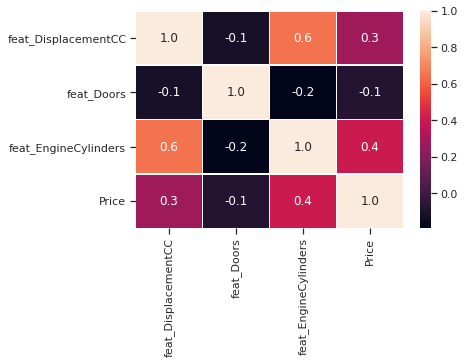

In [40]:
# generamos matriz de correlación entre los atributos númericos u ordinales y nuestro vector objetivo precio.
f,ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df_feat.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

### 2.2.1.2 Distribución y relación de los atributos categóricos "feat con el vector objetivo.

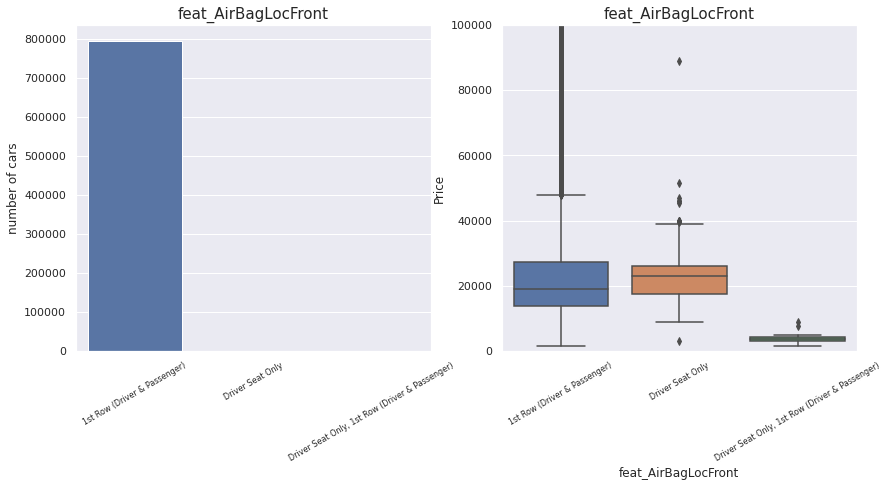

In [41]:
#Variable "feat_airbag"
fn.count_box_plot('feat_AirBagLocFront', df)

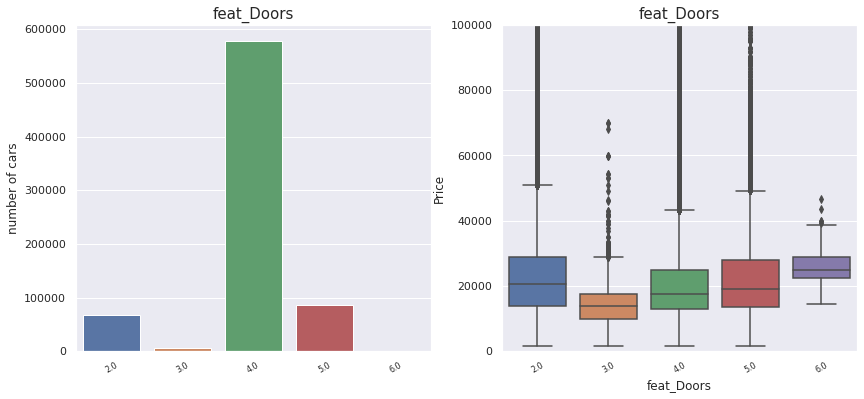

In [42]:
#Variable "feat_Doors"
fn.count_box_plot("feat_Doors", df)

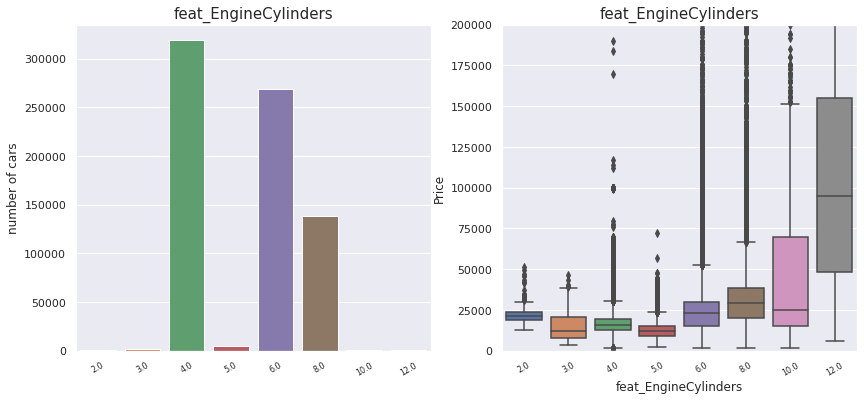

In [43]:
#Variable "feat_EngineCylinders"
fn.count_box_plot("feat_EngineCylinders",df, 200000)

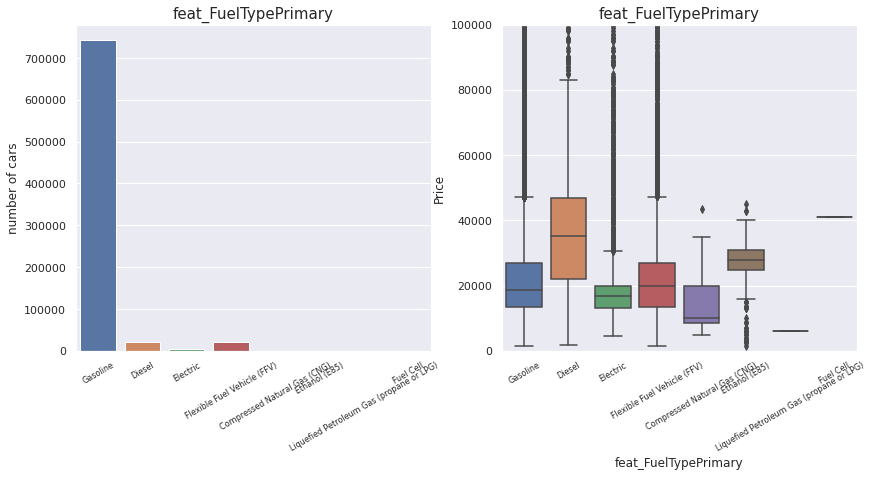

In [44]:
fn.count_box_plot("feat_FuelTypePrimary", df)

### Conclusiones atributos FEAT:

- Los atributos feat_Doors, feat_Airbag, feat_TPMS, feat_FuelType están considerablemente desbalanceadas hacia una categoría. No se recomiendan utilizar estas variables para el modelamiento de datos.
- Las tres variables relacionadas al Displacement presentan una correlación de 0.3 con el vector objetivo y se sugiere considerar en el modelamiento. Además, se sugiere considerar una de las tres.
- Respecto a la variable feat_EngineCylinders es necesario recodificarla ya que tiene valores con y sin puntos.

### 2.2.2 Distribución atributos Use:

#### 2.2.2.1 Matriz de correlación entre atributos "Use" númericos u ordinales con el vector objetivo.

In [45]:
# Generamos lista con columnas feat
col_names_use = [col for col in df.columns if 'use' in col]

In [46]:
#generamos df con columnas use más Price para hacer la matrix de correlación"
df_use = df[col_names_use]
df_use["Price"] = df["Price"]

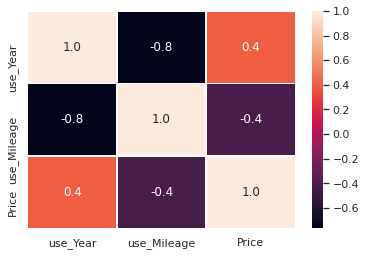

In [47]:
# generamos matriz de correlación entre los atributos númericos u ordinales y nuestro vector objetivo precio.
f,ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df_use.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

#### 2.2.2.2 Distribución y relación de los atributos categóricos "Use" con el vector objetivo.

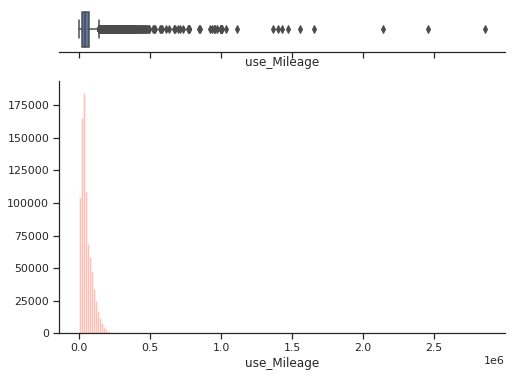

In [48]:
# Variable use_Mileage
fn.distrbution_graph(df.use_Mileage)

Text(0.5, 1.0, 'Mileage and Price relation ')

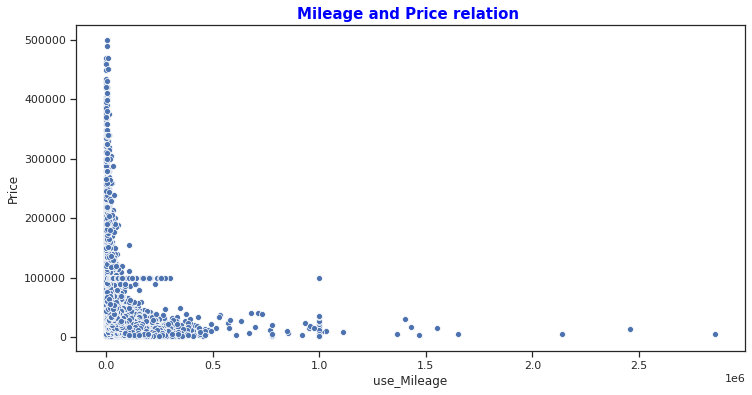

In [49]:
# observamos la distribución de use_Mileage en función del precio, mediante un scatterplot.
plt.figure(figsize=(12,6))
sns.scatterplot(y=df['Price'], x=df['use_Mileage']);
plt.title('Mileage and Price relation ',fontsize=15,color='blue',fontweight='bold')

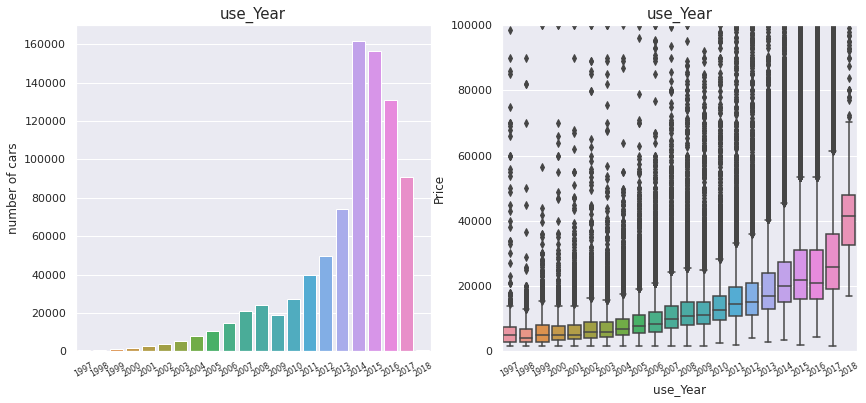

In [50]:
##Variable "Year"
fn.count_box_plot("use_Year", df)

### Conclusiones atributos USE:
- Existe una asociación positiva entre Year y el precio de vehículos.
- Existe una asociación negativa entre Mileage y el precio de los vehículos.
- Entre year y mileage exite una fuerte asociación negativa de 0.8. Dada esta asociación, quizás es recomendable elimnar una de estas variables.

### 2.2.3 Distribución atributos localization (loc):

#### 2.2.3.1 Distribución y relación de los atributos categóricos "Loc" con el vector objetivo.

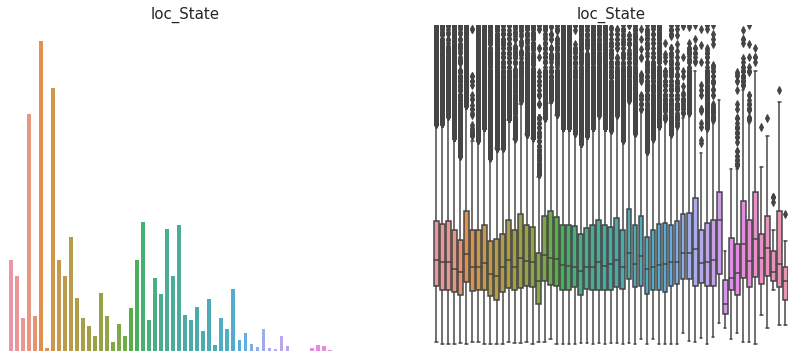

In [51]:
#Variable loc_state
fn.count_box_plot("loc_State",df, 70000,False)

Text(0.5, 1.0, 'City Distribution')

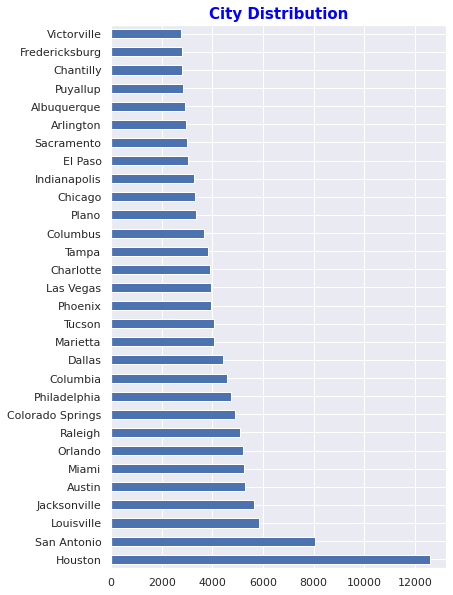

In [52]:
# observamos la distribución de loc_City, mediante un plot
df['loc_City'].value_counts().head(30).plot(kind='barh', figsize=(6,10))
plt.title('City Distribution',fontsize=15,color='blue',fontweight='bold')

### Conclusiones atributos LOC:

- El precio por State presenta una distribución similar. Esto se evidencia al observar los cuartiles y la mediana de los precios en cada uno de los estados. Solo el estado DC, presenta precios inferiores. Se recomienda no considerar esta variable por el momento.

- Dada la complejidad en cuanto al número de ciudades contenidas en la base de datos, por ahora no recomendamos utilizar esta variable en el proceso de entrenamiento. 

### 2.2.4 Distribución atributos de segmentacion (sgt):

#### 2.2.4.1 Distribución y relación de los atributos categóricos "de segmentación "SGT" con el vector objetivo.

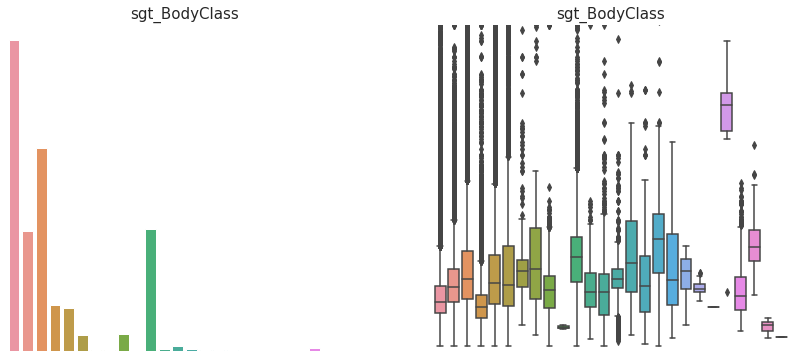

In [53]:
#variable sgt_BodyClass
fn.count_box_plot("sgt_BodyClass",df, 100000,False)                        

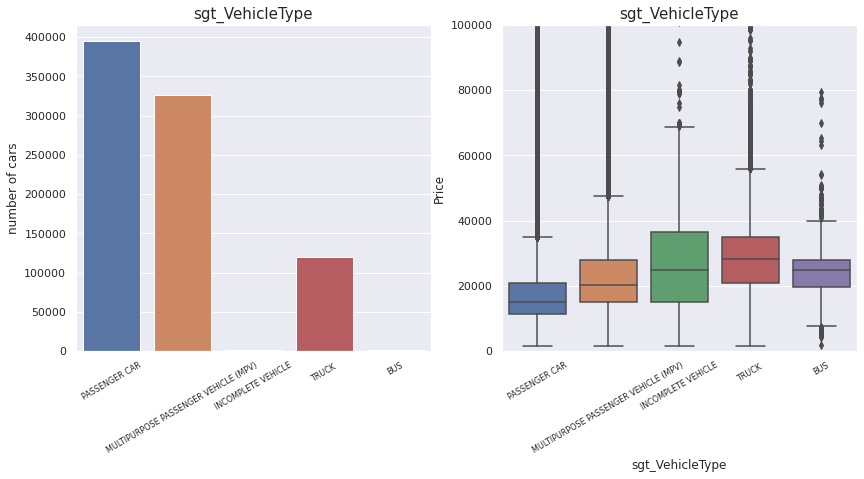

In [54]:
#Variable sgt_VehicleType
fn.count_box_plot("sgt_VehicleType", df)

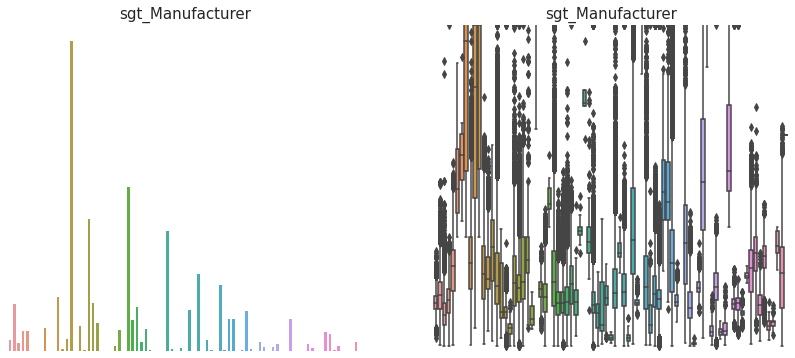

In [55]:
#Variable sgt_Manufacter
fn.count_box_plot("sgt_Manufacturer", df, 100000,False)

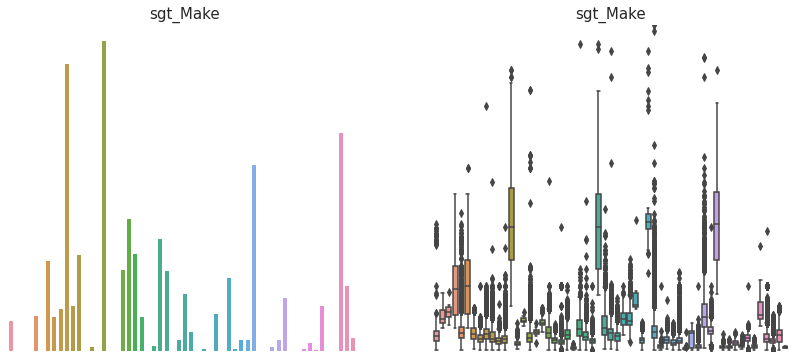

In [56]:
#variable sgt_Make
fn.count_box_plot("sgt_Make", df, 500000,False)

Text(0.5, 1.0, 'Model Distribution')

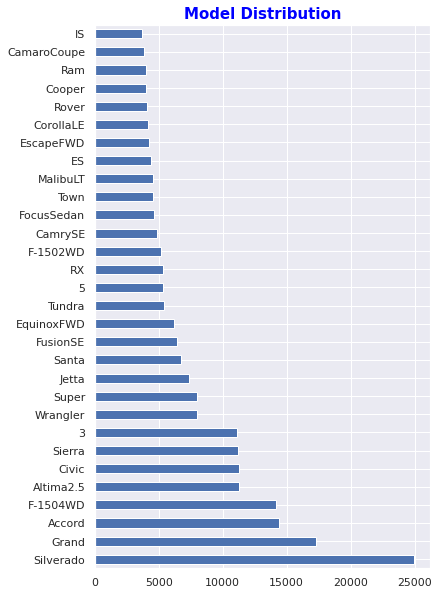

In [57]:
# observamos la distribución de sgt_model, mediante un plot
df['sgt_Model'].value_counts().head(30).plot(kind='barh', figsize=(6,10))
plt.title('Model Distribution',fontsize=15,color='blue',fontweight='bold')

### Conclusiones atributos de segmentación (sgt):

- Los atributos BodyClass, VehicleType, Make y Model y Manufacter muestran variaciones de los precios por categoría. Sin embargo, existen muchas categorías de estas variables con frecuencias muy bajas. Entonces, se recomienda utilizar estas variables previo a recodificación de las categprías marginales.  

### Selección de atributos para el entrenamiento:
Como resultado del Análisis de la distribución de los atributos y de la relación de ellos con el vector objetivo se decide seleccionar 5 atributos para la fase de entrenamiento de modelos:
0. Price (Vector Objetivo)
1. Mileage
2. BodyClass
3. PlantCountry
4. VehicleType
5. Model


### 2.2.5 Distribución atributos de fabricación (fab):

#### 2.2.5.1 Distribución y relación de los atributos categóricos de fabricación "fab" con el vector objetivo.

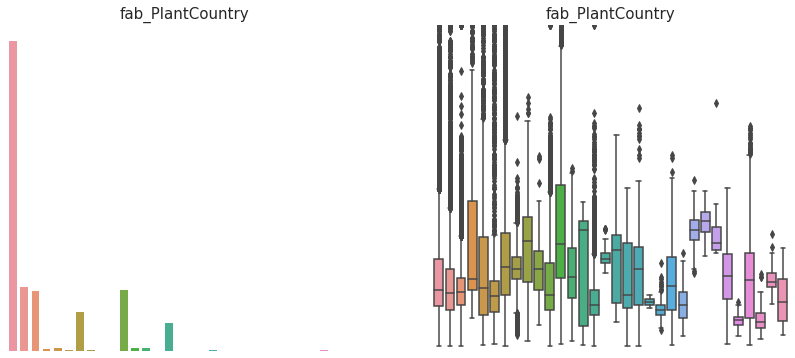

In [58]:
#Variable fab_PlantCountry
fn.count_box_plot("fab_PlantCountry",df, 100000,False)

### Conclusiones atributos de fabricación (fab):

- El atributo PlantCountry muestra variación de los precios entre paises. Sin embargo, también se observan frecuencias de paises marginales. Se recomienda utilizar esta variable para el entrenaminto de los datos previa recategorización.
- Respecto al atributo PlantCity, dada la gran cantidad de ciudades se recomienda no utilizar por ahora.

# 3. Recodificación de variables

## 3.1 Reagrupación de fab_PlantCountry

In [59]:
# reagrupamos el atributo fab_PlantCountry
df['fab_PlantCountry'] = df['fab_PlantCountry'].replace(
                         ['FRANCE','SPAIN', 'PORTUGAL', 'POLAND', 'NETHERLANDS', 'SERBIA', 'FINLAND',"ITALY","UNITED KINGDOM (UK)","AUSTRIA","HUNGARY","ENGLAND","BELGIUM","SWEDEN","SLOVAKIA"],'OTHERS_EUROPE').replace(
                         ['ARGENTINA','VENEZUELA', 'BRAZIL', 'UNITED STATES (USA), CANADA', 'CANADA, UNITED STATES (USA)'],'OTHERS_AMERICA').replace(
                         ['THAILAND','TURKEY', 'CHINA', 'AUSTRALIA', 'INDIA'],'OTHERS_ASIA_OCEANIA').replace(
                         ["OTHERS_AMERICA","OTHERS_ASIA_OCEANIA","SOUTH AFRICA"],"OTHER_COUNTRIES")

In [60]:
# vusalizamos la cantidad de datos para c/u de las variables de fab_PlantCountry
df.fab_PlantCountry.value_counts()

UNITED STATES (USA)    417236
JAPAN                   86370
MEXICO                  83087
CANADA                  81514
GERMANY                 53772
SOUTH KOREA             38222
OTHERS_EUROPE           29065
OTHER_COUNTRIES          8123
Name: fab_PlantCountry, dtype: int64

### Comenatrios fab_PlantCountry.

Las categorías que estan por debajo de los 600 registros, se agrupan en 2 grandes conjuntos: OTHER_EUROPE y OTHER_COUNTRY.
Como resultado de se obtienen 8 categorias.

## 3.2 Reagrupación de sgt_BodyClass

In [61]:
# reagrupamos el atributo sgt_BodyClass
df['sgt_BodyClass'] = df['sgt_BodyClass'].replace(
                      ["Hatchback/Liftback/Notchback, Convertible/Cabriolet"],"Hatchback/Liftback/Notchback").replace(
                      ["Wagon, Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)"],"Wagon").replace(
                      ["Incomplete - Cutaway","Incomplete - Cutaway","Incomplete - Chassis Cab (Number of Cab Unknown)","Incomplete - Chassis Cab (Double Cab)","Incomplete - Stripped Chassis","Incomplete - Commercial Chassis","Incomplete - Motor Home Chassis","Incomplete - Chassis Cab (Single Cab)","Incomplete - Chassis Cab (Double Cab) "],"Incomplete").replace(
                      ["Truck"],"Sport Utility Truck (SUT)").replace(
                      ["Roadster"],"Convertible/Cabriolet").replace(
                      ["Cargo Van"],"Minivan")

In [62]:
# reemplazamos con np.nan, aquellas variables del atributo sgt_BodyClass que tienen una frecuencia marginal 
df = df.replace({'sgt_BodyClass':{"Bus":np.NaN,"Limousine":np.NaN,'Trailer':np.NaN,"Incomplete":np.NaN}})

In [63]:
# vusalizamos la cantidad de datos para c/u de las variables de sgt_BodyClass
df.sgt_BodyClass.value_counts()

Sedan/Saloon                                               294628
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    192158
Pickup                                                     115583
Wagon                                                      113966
Hatchback/Liftback/Notchback                                43629
Coupe                                                       40817
Minivan                                                     17677
Convertible/Cabriolet                                       15612
Van                                                          4857
Crossover Utility Vehicle (CUV)                              2637
Sport Utility Truck (SUT)                                    1656
Name: sgt_BodyClass, dtype: int64

## comentarios sgt_BodyClass

Se agrupan las categorías según automóviles similares. El criterio usado fue juicio experto.
Se decide transformar a NaN las categorías específicas: Bus, Limousine e Incomplete.
Como resultado nos quedamos con 11 tipos de vehiculos.

## 3.3 Reagrupación de sgt_VehicleType

In [64]:
# reemplazamos con np.nan, aquellas variables del atributo sgt_VehicleType que tienen una frecuencia marginal 
df = df.replace({'sgt_VehicleType':{"INCOMPLETE VEHICLE":np.NaN,"BUS":np.NaN,"TRAILER":np.NaN}})

In [65]:
# vusalizamos los Q para c/u de las variables de sgt_VehicleType
df.sgt_VehicleType.value_counts()

PASSENGER CAR                           395708
MULTIPURPOSE PASSENGER VEHICLE (MPV)    326962
TRUCK                                   119952
Name: sgt_VehicleType, dtype: int64

## comentarios sgt_VehicleType

Dado que dentro del atributo `sgt_VehicleType` tenemos variables con una frecuencia muy marginal, se decide no considerarlas, por lo que se transforman a np.nan, quedandonos solo con 3 categorias de vehiculo:

* De pasajeros
* Multiproposito
* Camión

Lo que está muy relacionado con los tipos de vehiculos que comercializa una automotora.

In [66]:
# Filtrar 30 modelos
modelos = df['sgt_Make'].value_counts()
df = df[df['sgt_Make'].isin(modelos[modelos > 30].index)]

## 3.5 Recodificación de variable año

In [67]:
df['use_Oldest'] = df['use_Year'] - 2018

# 4. Preproceso

In [68]:
# Liberar Espacio Memoria
del df_api
del df_data
del df_train
del df_test

In [69]:
# Selección de variables para modelos
select_vars = ['Price', 'use_Mileage', 'sample', 'sgt_BodyClass', 'sgt_Make', 'use_Oldest']
#sample_size = df[select_vars].shape[0]

In [70]:
# Muestra aleatoria
df_sample = df[select_vars]\
                .sample(sample_size)\
                .reset_index(drop=True)\

In [71]:
# Instanciar clase para realizar preproceso
df_prep = PrepML(df_sample)

In [72]:
# Realizamos OneHot Encoder a las columnas categóricas seleccionadas
df_prep.one_hot_encoder(['sgt_BodyClass', 'sgt_Make'], drop_first=True)

In [73]:
# Removemos outliers (opcional)
#df_prep.remove_outliers(['Price', 'Mileage'], multiplier=1.5)
#df_prep.df

In [74]:
# Estandarizamos variables continuas seleccionadas
df_prep.standard_scaler(['use_Mileage', 'use_Oldest'])

In [75]:
# Separar muestras según
X_train, y_train, X_test, y_test = df_prep.to_train_test_samples('sample', 'Price')

Realizado en 0.0s


In [86]:
X_train.shape

(149371, 63)

# 5. Modelamiento 

In [77]:
# Test
from sklearn.linear_model import LinearRegression
linear_reg = MLModel(LinearRegression())
linear_reg.fit(X_train, y_train)

Realizado en 1.0s


In [78]:
linear_reg.metrics(X_test, y_test)

rmse: 12634.2
mae: 7810.1
r2: 0.182


{'rmse': 12634.2, 'mae': 7810.1, 'r2': 0.182}

## 5.1 Ridge Regression

In [79]:
# Establecemos parámetros a evaluar en el modelo
ridge_grid = {'alpha': [0, .001, 0.0001],
              'solver': ['sag', 'sparse_cg']}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
ridge_reg = MLModel(model=Ridge(fit_intercept=True))
# Implementación del grid search
ridge_reg.grid_search(X_train,
                      y_train,
                      param_grid=ridge_grid,
                      n_jobs=-2,
                      cv=cv)

Mejores parámetros:
{'alpha': 0.0001, 'solver': 'sparse_cg'}

Realizado en 74.0s


In [80]:
# Métricas
ridge_reg.metrics(X_test, y_test)

rmse: 12633.5
mae: 7809.4
r2: 0.183


{'rmse': 12633.5, 'mae': 7809.4, 'r2': 0.183}

## 5.2 SGD

In [81]:
# Establecemos parámetros a evaluar en el modelo
sgd_grid = {'loss': ['squared_epsilon_insensitive', 'squared_loss'],
            'alpha': [0, 0.0001, 0.00001]
          }
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
sgd_reg = MLModel(model=SGDRegressor(penalty = 'l1',
                                     early_stopping = False,
                                     random_state=rd_seed))
# Implementación del grid search
sgd_reg.grid_search(X_train,
                    y_train,
                    param_grid=sgd_grid,
                    n_jobs=3,
                    cv=cv)

Mejores parámetros:
{'alpha': 0.0001, 'loss': 'squared_loss'}

Realizado en 19.0s


In [82]:
sgd_reg.metrics(X_test, y_test)

rmse: 12636.4
mae: 7809.6
r2: 0.182


{'rmse': 12636.4, 'mae': 7809.6, 'r2': 0.182}

## 5.3 LightGBM

In [83]:
# Establecemos parámetros a evaluar en el modelo
lgb_grid = {'max_depth': [3, 4, 5, 6], 
            'num_leaves': [30, 50, 60]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
lgb_reg = MLModel(model=LGBMRegressor(n_jobs=1,
                                      random_state=rd_seed))
# Implementación del grid search
lgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=lgb_grid,
                    n_jobs=-2,
                    cv=cv)

Mejores parámetros:
{'max_depth': 5, 'num_leaves': 30}

Realizado en 13.0s


In [84]:
lgb_reg.metrics(X_test, y_test)

rmse: 12148.3
mae: 7526.3
r2: 0.244


{'rmse': 12148.3, 'mae': 7526.3, 'r2': 0.244}

## 5.4 XGBoost

In [85]:
# Establecemos parámetros a evaluar en el modelo
xgb_grid = {'max_depth': [4, 5, 6, 7], 
            'n_estimators': [ 60, 70, 80]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
xgb_reg = MLModel(model=XGBRegressor(objective ='reg:squarederror',
                                     n_jobs=1,
                                     seed=rd_seed))
# Implementación del grid search
xgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=xgb_grid,
                    n_jobs=-2,
                    cv=cv)

exception calling callback for <Future at 0x7f1e00974e48 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/queues.py", line 99, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/h

KeyboardInterrupt: 

In [ ]:
# Métricas
xgb_reg.metrics(X_test, y_test)

In [ ]:
break

# Experimental: Red Neuronal

In [ ]:
# Clase para instanciar modelos de Keras como objetos de scikit-learn
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# Regularizador para neuronas
from tensorflow.keras.regularizers import l2
# Arquitectura secuencial para modelos de redes neuronales
from tensorflow.keras.models import Sequential
# Clase para conexciónes densamente pobladas
from tensorflow.keras.layers import Dense

In [ ]:
# Norma de regularización con lambda=0.01
ridge_regularizer = l2(0.0005)


# Instanciamos la Red Neuronal
input_dim = (X_train.shape[1],)
model = Sequential()
model.add(Dense(20, activation='relu',
                kernel_regularizer = ridge_regularizer,
                use_bias=True, 
                input_shape=input_dim,
                name='Primera_capa'))

model.add(Dense(10, activation='relu', 
                kernel_regularizer = ridge_regularizer,
                use_bias=True, 
                name='Segunda_capa'))

model.add(Dense(1, activation='linear', use_bias=True, name='output'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

In [ ]:
model.fit(X_train, y_train, batch_size=512, epochs=50, validation_data=(X_test, y_test))